In [1]:
import json
import itertools
import re
import datetime
from difflib import SequenceMatcher
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
table = pd.read_csv("fighters_table_May_28.csv")

C:\Users\User\Anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (50,63,66,67,68,183,198,258,273,325,330,337,342,385,390,397,402,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def decode_seconds(string):
    if isinstance(string,float): 
        return string
    if string == "M/A":
        return 0
    if ':' not in string:
        return int(string)
    
    x = re.findall('\d+', string)
    if not x[0]:
        return float(x[1])/60
    elif len(x) < 2:
        return float(x[0])
    
    return float(x[0]) + float(x[1])/60

def timedecoding(fround,time,time_format):
    #round, time, time format
    if pd.isna(time_format) or time_format == 'NaN':
        if not pd.isna(time) and not pd.isna(fround):
            return ((float(fround)-1)*5) + decode_seconds(time)
        else:
            return None
    else:
        if re.search('No Time Limit',time_format) or re.search("1 Rnd", time_format) or re.search("Unlimited Rnd", time_format):
            return decode_seconds(time)
        else:
            time_format = time_format[time_format.index("(")+1:time_format.index(")")]
            fought = decode_seconds(time)
            for x in time_format.split('-')[:round(int(fround)-1)]:
                fought += int(x)
            return fought

In [4]:
table['approx_length'] = table[['round','time','time format']].apply(lambda x: timedecoding(x['round'],x['time'],x['time format']),axis=1)
table["weightclass"] = table["weightclass"].apply(lambda x: x.strip() if not pd.isna(x) else np.NaN)
table['weightclass'] = table[['weightclass','Woman']].apply(lambda x: x['weightclass'] if not x['Woman'] else 'Women ' + str(x['weightclass']),axis=1) 
table["Last Fight"] = table["Last Fight"].astype(np.datetime64)
table["SinceLastFight"] = datetime.datetime.today() -  (table["Last Fight"].astype(np.datetime64))
table["SinceThisFight"] = datetime.datetime.today() -  (table["date"].astype(np.datetime64))

In [5]:
table['UFC win'] = table[['result','UFC']].apply(lambda x: 1 if (x['UFC']==1 and x['result']=='win') else 0,axis=1)
table['UFC loss'] = table[['result','UFC']].apply(lambda x: 1 if (x['UFC']==1 and x['result']=='loss') else 0,axis=1)
table['UFC draw'] = table[['result','UFC']].apply(lambda x: 1 if (x['UFC']==1 and x['result']=='draw') else 0,axis=1)

In [6]:
table['SinceLastFight_UFC'] = table[["SinceLastFight",'UFC']].apply(lambda x: x['SinceLastFight'] if x['UFC']==1 else np.NaN,axis=1)

In [ ]:
#Creating is done

In [30]:
attempted = table[["Name","UFC",'weightclass',"Woman","tot f TOTAL STR att","tot f TD att","approx_length","SinceLastFight","tot o TD att","tot o TD lan","TD Def"]].copy()

In [31]:
attempted['total_strikes_attempted_per_minute'] = table["tot f TOTAL STR att"] / table["approx_length"]
attempted['total_takedown_attempted_per_minute'] = table["tot f TD att"] / table["approx_length"]
attempted["percent of defended takedowns"] = table["tot f TD att"] / table["approx_length"]
attempted["TD Def"] = attempted["TD Def"].apply(lambda x: x.strip('%')).astype(np.float32)

In [32]:
attempted_groupped = attempted[(attempted['weightclass'] == 'Lightweight') & (attempted['UFC']==1)].groupby('Name').agg({'total_strikes_attempted_per_minute':'mean',
                                                                                                                         'total_takedown_attempted_per_minute':'mean',
                                                                                                                         'UFC':'sum',
                                                                                                                         "SinceLastFight":'min',
                                                                                                                         "TD Def":'mean'})

In [33]:
attempted_groupped = attempted_groupped[(attempted_groupped['UFC'] > 4) & (attempted_groupped["SinceLastFight"].dt.days < 1000)]

In [55]:
from palettable.cartocolors.sequential import Mint_7

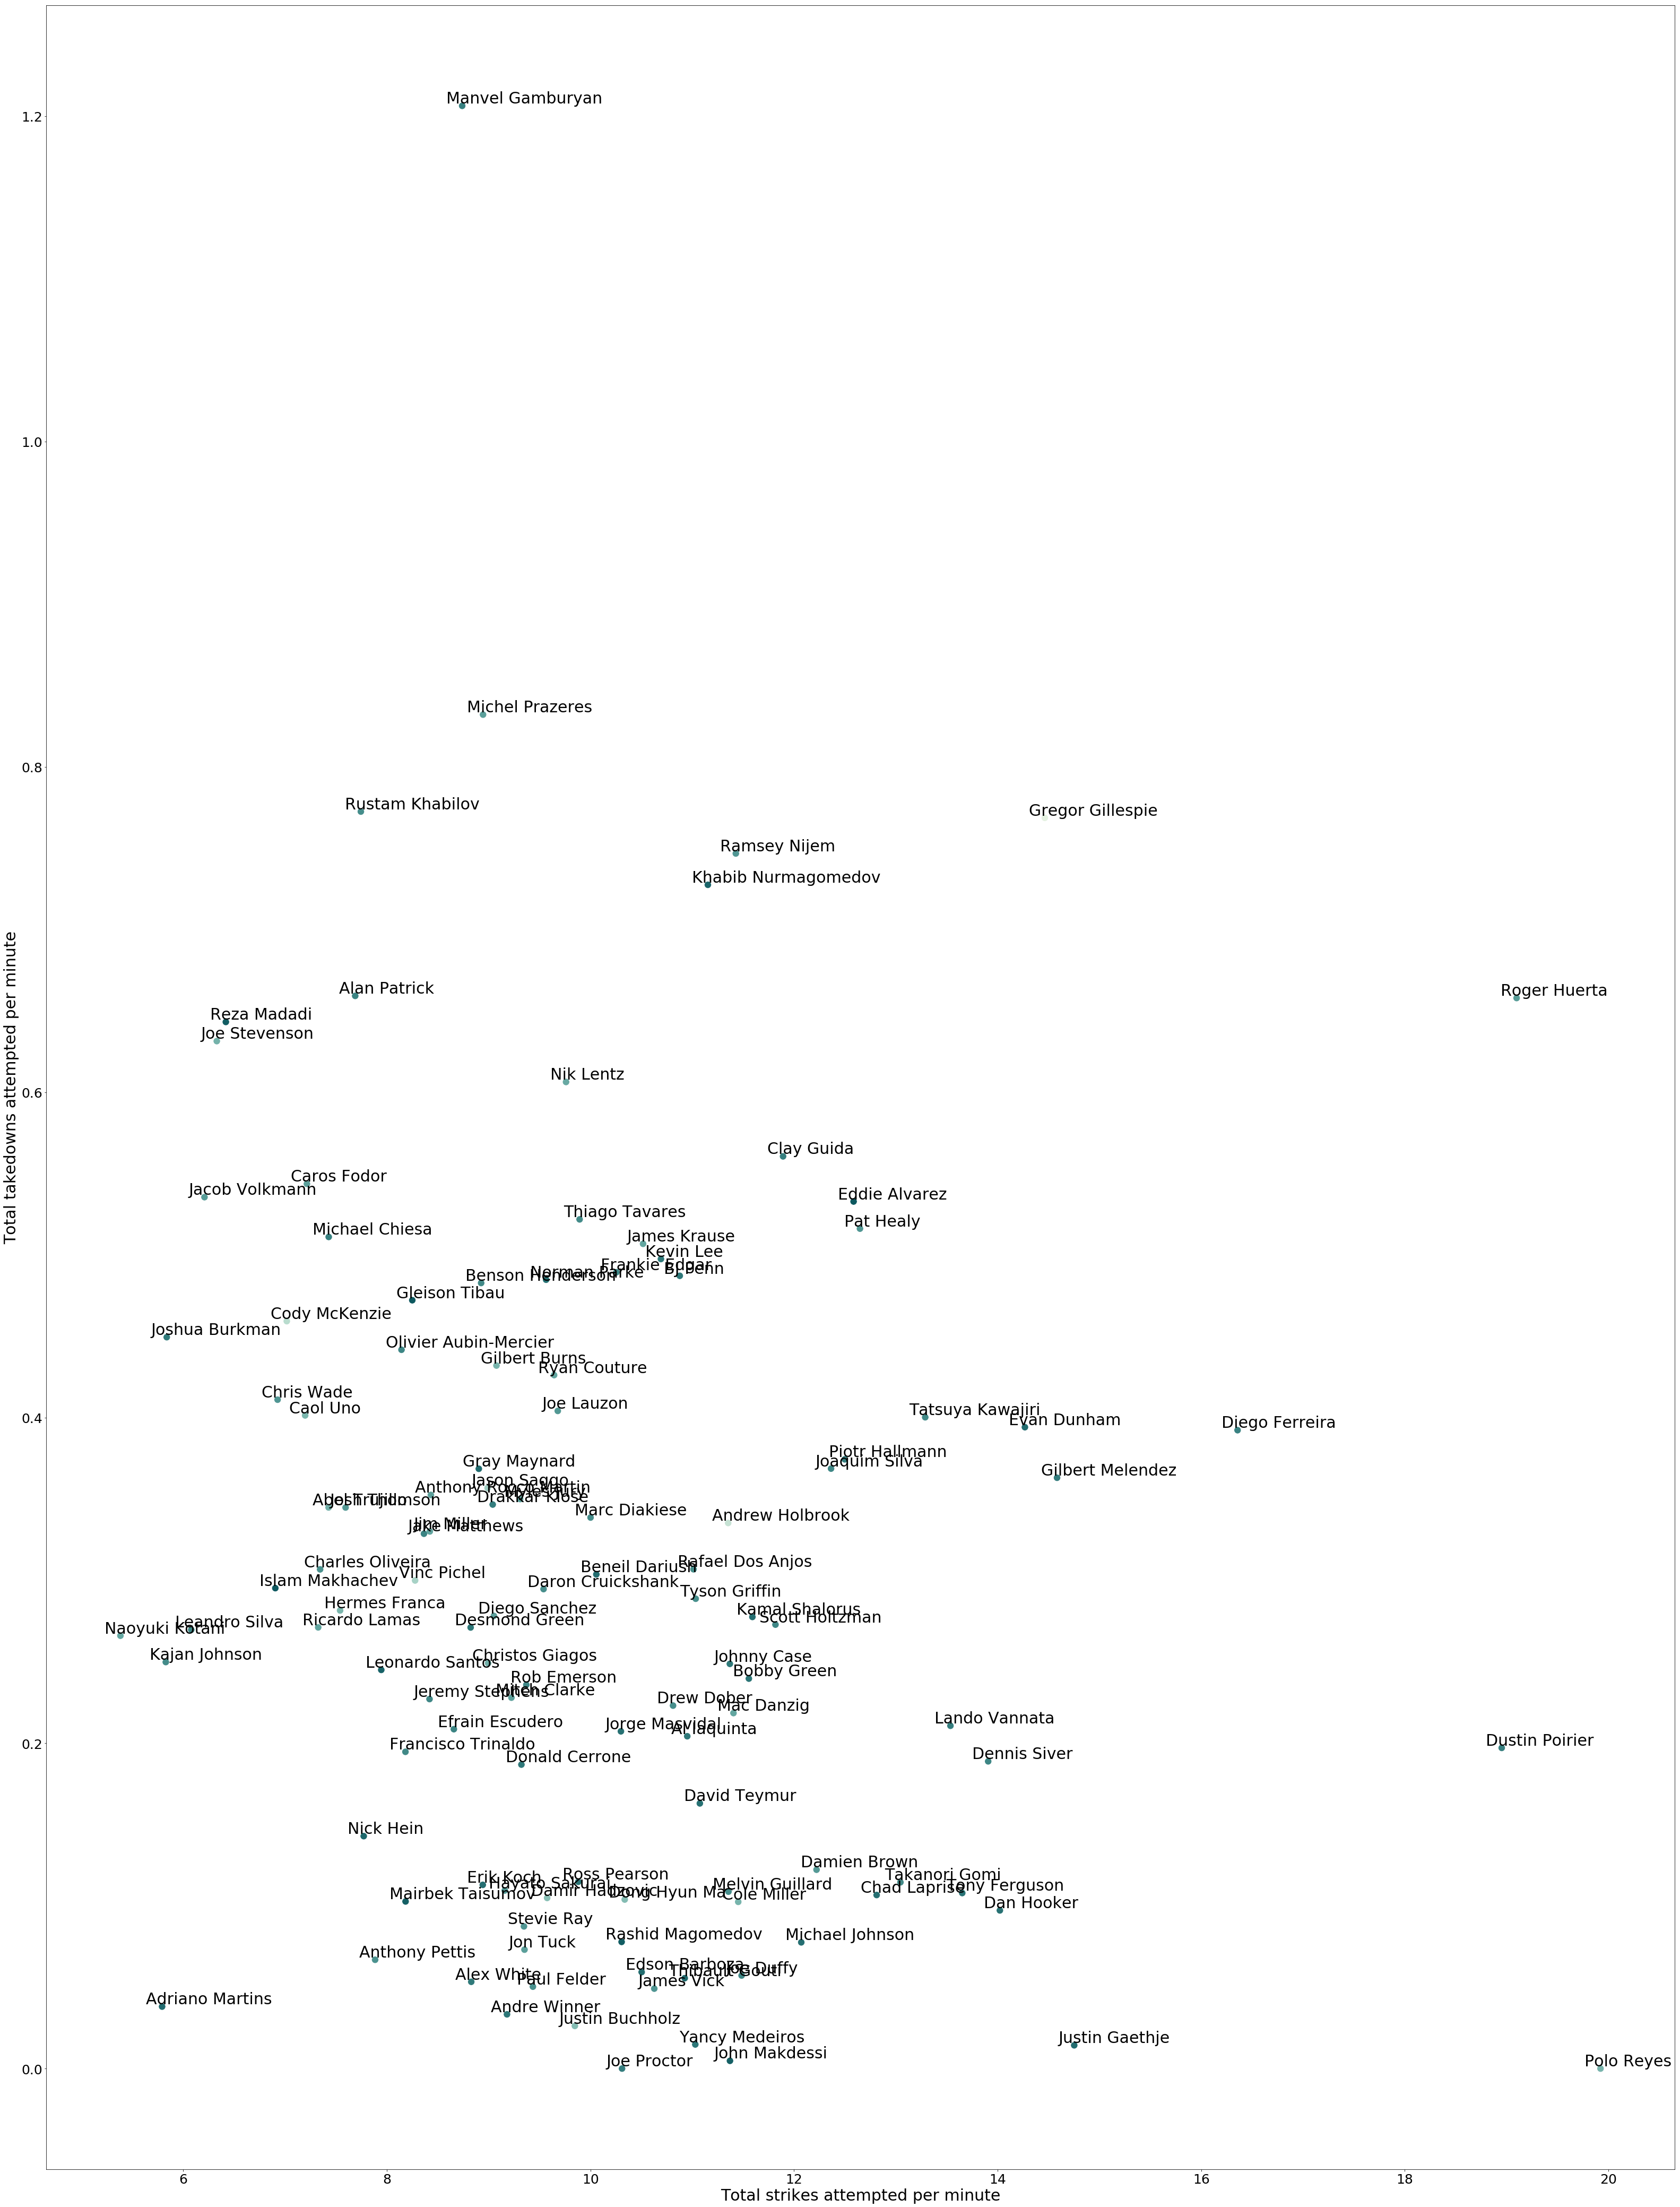

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(55,75)



ax.scatter(x=attempted_groupped["total_strikes_attempted_per_minute"],
           y=attempted_groupped["total_takedown_attempted_per_minute"],
           c=attempted_groupped['TD Def'],
           s=130,cmap=Mint_7.mpl_colormap,marker='o')

ax.tick_params(labelsize=25)
ax.set_xlabel('Total strikes attempted per minute',size=30)
ax.set_ylabel('Total takedowns attempted per minute',size=30)

for xx in attempted_groupped.iterrows():
    ax.annotate(xx[0], (xx[1][0], xx[1][1]),textcoords='offset points',xytext=(-30,5),size=30)
plt.savefig('Total strikes and takedowns.png',dpi=120)

#weight classes landed percent

In [156]:
weight_classes = table[["Name","UFC",'weightclass',"Woman",'tot f KD','tot f SIG STR lan','tot f SIG STR att',"approx_length",""]].copy()

In [157]:
weight_classes['Sig str att pm'] = weight_classes['tot f SIG STR att'].values / weight_classes["approx_length"].values
weight_classes['Sig str lan pm'] = weight_classes['tot f SIG STR lan'].values / weight_classes["approx_length"].values
weight_classes['Sig str lan proc'] = weight_classes['tot f SIG STR lan'].values / weight_classes['tot f SIG STR att'].values
weight_classes['Sig str per kd'] = weight_classes['tot f SIG STR lan'].values / weight_classes['tot f KD'].values
weight_classes['weightclass'] = weight_classes[['weightclass','Woman']].apply(lambda x: x['weightclass'] if not x['Woman'] else 'Women ' + str(x['weightclass']),axis=1) 
weight_classes_gr = weight_classes[weight_classes['UFC']==1].groupby(['Name','weightclass']).agg({'Sig str att pm':'mean',
                                                                                  'Sig str lan pm':'mean',
                                                                                  'Sig str lan proc':'mean',
                                                                                  'UFC':'sum'})

C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd fr

In [158]:
weight_classes_gr.reset_index(inplace=True)

In [159]:
weight_classes_gr.weightclass.unique()

array(['Heavyweight', 'Bantamweight', 'Featherweight', 'Lightweight',
       'Welterweight', 'Light Heavyweight', 'Middleweight', 'Catchweight',
       'Women Strawweight', 'Flyweight', 'Women Bantamweight',
       'Women Flyweight', 'Women Catchweight', 'Women Featherweight',
       'Super Heavyweight', 'Women Atomweight', 'Women Welterweight'],
      dtype=object)

In [160]:
weight_classes_gr = weight_classes_gr[np.invert(weight_classes_gr['weightclass'].isin(['Women Atomweight','Women Welterweight','Super Heavyweight','Women Catchweight','Flyweight','Women Featherweight','Catchweight']))]

In [163]:
weight_classes_gr = weight_classes_gr[weight_classes_gr['UFC'] >= 4]

In [ ]:
pd.melt(df, id_vars =['Name'], value_vars =['Course', 'Age']

In [181]:
weight_classes_gr.head()

,Name,weightclass,Sig str att pm,Sig str lan pm,Sig str lan proc,UFC
3,Aaron Riley,Lightweight,11.164656,3.734788,0.330804,8
6,Aaron Rosa,Light Heavyweight,5.638421,2.465942,0.431490,4
7,Aaron Simpson,Middleweight,9.679921,4.856382,0.527742,10
10,Abdul Razak Alhassan,Welterweight,16.710688,9.404965,0.506129,5
12,Abel Trujillo,Lightweight,6.264289,2.651440,0.408341,11


In [185]:
melted_weight_class = pd.melt(weight_classes_gr,id_vars=['weightclass'],value_vars=["Sig str att pm","Sig str lan pm"])

In [186]:
melted_weight_class

,weightclass,variable,value
0,Lightweight,Sig str att pm,11.164656
1,Light Heavyweight,Sig str att pm,5.638421
2,Middleweight,Sig str att pm,9.679921
3,Welterweight,Sig str att pm,16.710688
4,Lightweight,Sig str att pm,6.264289
5,Lightweight,Sig str att pm,5.445990
6,Lightweight,Sig str att pm,6.957143
7,Welterweight,Sig str att pm,5.261287
8,Featherweight,Sig str att pm,7.741892
9,Lightweight,Sig str att pm,10.558270


In [198]:
melted_weight_class = melted_weight_class[melted_weight_class['value'] < 20]

In [199]:
sns.set(style="whitegrid", palette="muted")

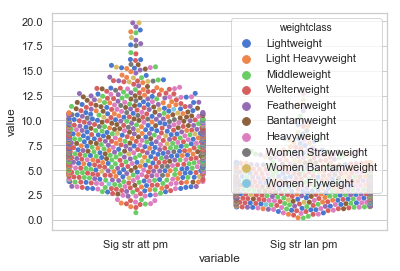

In [200]:
sns.swarmplot(x='variable',y='value',hue='weightclass',data=melted_weight_class)

In [166]:
sns.set(style="whitegrid", palette="muted")

# Load the example iris dataset
iris = sns.load_dataset("iris")

In [125]:
weight_classes_gr = weight_classes_gr[weight_classes_gr['tot f SIG STR att'] > 13000].reset_index()

In [127]:
weight_classes_gr['Sig str att pm'] = weight_classes_gr['tot f SIG STR att'].values / weight_classes_gr["approx_length"].values
weight_classes_gr['Sig str lan pm'] = weight_classes_gr['tot f SIG STR lan'].values / weight_classes_gr["approx_length"].values
weight_classes_gr['Sig str lan proc'] = weight_classes_gr['tot f SIG STR lan'].values / weight_classes_gr['tot f SIG STR att'].values
weight_classes_gr['Sig str per kd'] = weight_classes_gr['tot f KD'].values / weight_classes_gr['tot f SIG STR lan'].values

In [129]:
weight_classes_gr['Sig str per kd'] = weight_classes_gr['tot f KD'].values / weight_classes_gr['tot f SIG STR lan'].values

In [130]:
weight_classes_gr

,weightclass,tot f SIG STR att,tot f SIG STR lan,approx_length,tot f KD,Sig str att pm,Sig str lan pm,Sig str lan proc,Sig str per kd
0,Bantamweight,75230.0,29811.0,9210.516667,211.0,8.167837,3.236626,0.396265,0.007078
1,Featherweight,88875.0,36995.0,11233.683333,216.0,7.911475,3.293221,0.416259,0.005839
2,Flyweight,32371.0,13100.0,4553.283333,71.0,7.109375,2.877045,0.404683,0.005420
3,Heavyweight,69592.0,32801.0,12752.066667,337.0,5.457311,2.572211,0.471333,0.010274
4,Light Heavyweight,68554.0,30914.0,10311.716667,276.0,6.648166,2.997949,0.450944,0.008928
5,Lightweight,175199.0,71922.0,24036.450000,442.0,7.288888,2.992206,0.410516,0.006146
6,Middleweight,102788.0,45414.0,16821.450000,431.0,6.110531,2.699767,0.441822,0.009490
7,Welterweight,152157.0,65643.0,22495.700000,514.0,6.763826,2.918024,0.431416,0.007830
8,Women Bantamweight,24451.0,10699.0,2872.533333,21.0,8.511999,3.724587,0.437569,0.001963
9,Women Strawweight,34444.0,14728.0,3600.266667,17.0,9.567069,4.090808,0.427593,0.001154


Sig ansorbed and sig landed

In [44]:
table.columns.values

array(['Name', 'Woman', 'Nickname', 'Height in', 'Reach in', 'Stance',
       'Sig Land pm', 'Strik acc', 'Sig Absorb pm', 'Strik def', 'TD Avg',
       'TD acc', 'TD Def', 'Sub Avg', 'DoB', 'Height cm', 'Wins', 'Loses',
       'draws', 'nc', 'Affil', 'National', 'Loc reg', 'Loc city', 'W KO',
       'W sub', 'W dec', 'W oth', 'L KO', 'L sub', 'L dec', 'L oth',
       'Giv name', 'Reach cm', 'Height cm.1', 'Last Fight', 'Born',
       'Fight out of', 'fr wins', 'fr loses', 'fr draws', 'opponent',
       'or wins', 'or loses', 'or draws', 'result', 'round', 'time',
       'method', 'decision', 'injuries', 'weightclass', 'wcls weight',
       'weigh-in', 'fighter title', 'fights title name', 'referee',
       'fight time', 'billing', 'odds', 'event', 'pay', 'date',
       'dc reason', 'UFC', 'fight bonus', 'perf bonus', 'sub bonus',
       'ko bonus', 'off method', 'off round', 'title fight', 'details',
       'off time', 'time format', 'off referee', 'f card1', 'op card1',
       'f car

In [106]:
distance_visual = table[["Name","UFC","sig f DISTANCE lan",
                         "sig o DISTANCE lan",
                         "approx_length",
                         'weightclass',
                         "SinceLastFight",
                         "tot o KD",
                         "tot o SIG STR lan",
                         "Sig Absorb pm",
                         "Sig Land pm","UFC win","SinceLastFight_UFC"]].copy()
distance_visual['DISTANCE_lan_pm'] = distance_visual["sig f DISTANCE lan"].values / distance_visual["approx_length"].values
distance_visual['DISTANCE_abs_pm'] = distance_visual["sig o DISTANCE lan"].values / distance_visual["approx_length"].values


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
vis = distance_visual[(distance_visual['weightclass'] == 'Light Heavyweight') & (distance_visual['UFC']==1)].groupby('Name').agg({'Sig Absorb pm':'mean',
                                                                                                                                  'Sig Land pm':'mean',
                                                                                                                                  'UFC win':'sum',
                                                                                                                                 "SinceLastFight_UFC":'min'})
visless =  vis[(vis['UFC win'] >= 3) & (vis["SinceLastFight_UFC"].dt.days < 500)]

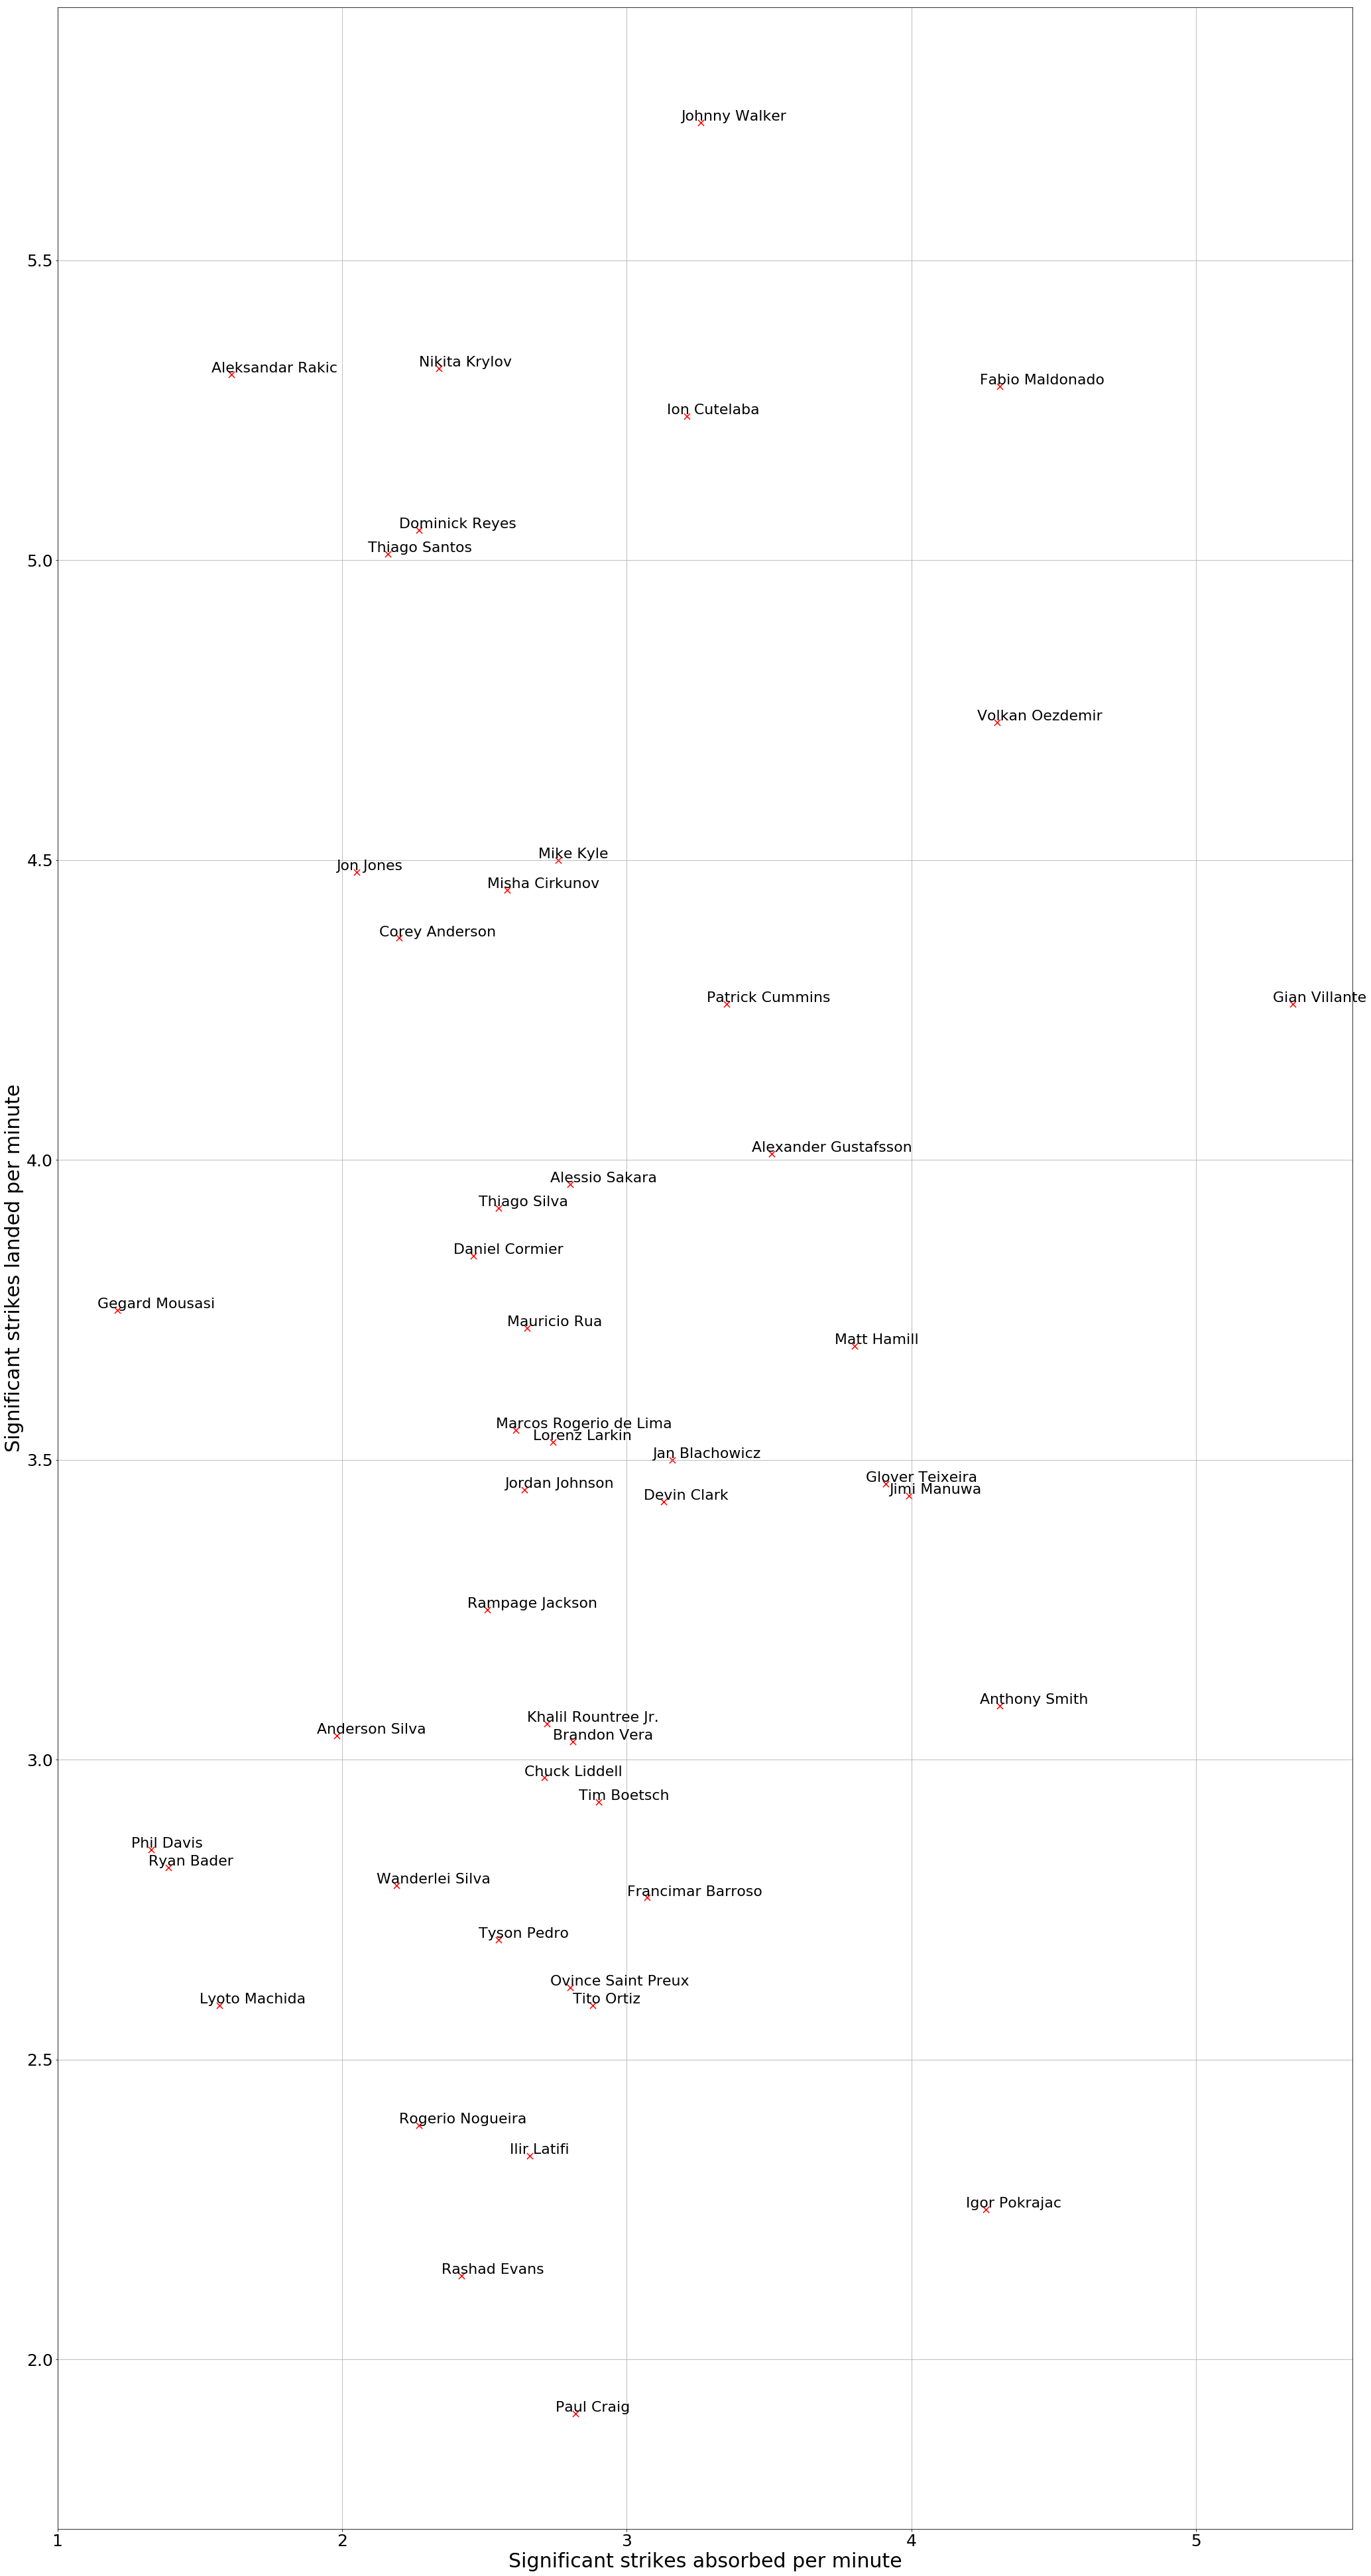

In [109]:
fig, ax = plt.subplots()
fig.set_size_inches(35,70)
ax.scatter(visless["Sig Absorb pm"],visless["Sig Land pm"],marker='x',s=85,c='r')
ax.set_xlabel('Significant strikes absorbed per minute',size=30)
ax.set_ylabel('Significant strikes landed per minute',size=30)
ax.grid(True)
ax.tick_params(labelsize=25)

for xx in visless.iterrows():
    ax.annotate(xx[0], (xx[1][0], xx[1][1]),textcoords='offset points',xytext=(-30,3),size=22)
plt.savefig('SigStrieks.png',dpi=150)

C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [140]:
#Barplot

In [51]:
distance_visual = table[["Name","UFC","tot f SIG STR lan","tot o SIG STR lan","approx_length",'weightclass',"tot o KD",
                         "SinceLastFight","Sig Absorb pm","Sig Land pm","UFC win","SinceLastFight_UFC",'SinceThisFight']].copy()

In [49]:
distance_visual["tot f SIG STR lan"]

0         0.0
1         0.0
2         0.0
3         2.0
4         2.0
5         2.0
6         2.0
7         2.0
8         7.0
9         7.0
10        7.0
11        3.0
12        0.0
13        NaN
14        9.0
15        NaN
16        NaN
17        7.0
18       19.0
19        NaN
20        3.0
21        3.0
22        3.0
23        NaN
24        3.0
25        3.0
26        3.0
27        NaN
28        NaN
29        NaN
         ... 
41354     NaN
41355     NaN
41356     NaN
41357     NaN
41358     NaN
41359     NaN
41360     NaN
41361     NaN
41362     NaN
41363     NaN
41364     NaN
41365     NaN
41366     NaN
41367     NaN
41368     NaN
41369     NaN
41370    61.0
41371    16.0
41372     NaN
41373     NaN
41374     NaN
41375     NaN
41376     NaN
41377     NaN
41378     NaN
41379     NaN
41380     NaN
41381     4.0
41382    49.0
41383    43.0
Name: tot f SIG STR lan, Length: 41384, dtype: float64

In [52]:
distance_visual['sig_str_lan_pm'] = distance_visual["tot f SIG STR lan"].values / distance_visual["approx_length"].values
distance_visual['sig_str_abs_pm'] = distance_visual["tot o SIG STR lan"].values / distance_visual["approx_length"].values


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
distance_visual = distance_visual[distance_visual['SinceThisFight'].dt.days > 100]

In [30]:
#distance_visual =  distance_visual[distance_visual["SinceLastFight_UFC"].dt.days > 1500]

In [53]:
distance_visual['punches_to_get_koed']

0             NaN
1             NaN
2             NaN
3        0.000000
4        0.000000
5        0.000000
6        0.000000
7        0.000000
8             NaN
9             NaN
10            NaN
11       0.000000
12            NaN
13            NaN
14       0.000000
15            NaN
16            NaN
17       0.000000
18       0.000000
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24       0.000000
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
           ...   
41354         NaN
41355         NaN
41356         NaN
41357         NaN
41358         NaN
41359         NaN
41360         NaN
41361         NaN
41362         NaN
41363         NaN
41364         NaN
41365         NaN
41366         NaN
41367         NaN
41368         NaN
41369         NaN
41370    0.000000
41371    0.037037
41372         NaN
41373         NaN
41374         NaN
41375         NaN
41376         NaN
41377         NaN
41378     

In [19]:
vis = distance_visual[(distance_visual['weightclass'] == 'Light Heavyweight') & (distance_visual['UFC']==1)].groupby('Name').agg({'Sig Absorb pm':'mean',
                                                                                                                                  'Sig Land pm':'mean',
                                                                                                                                  'UFC win':'sum',
                                                                                                                                 "SinceLastFight_UFC":'min'})

In [54]:
vis = distance_visual[(distance_visual['weightclass'] == 'Heavyweight') & (distance_visual['UFC']==1)].groupby('Name').agg({'sig_str_lan_pm':'mean',
                                                                                                                                  'sig_str_abs_pm':'mean',
                                                                                                                                  'UFC win':'sum',
                                                                                                                                 "SinceLastFight_UFC":'min'})

visless =  vis[vis['UFC win'] >= 4]
#visless =  vis[(vis['UFC win'] >= 3) & (vis["SinceLastFight_UFC"].dt.days < 500)]

In [36]:
visless['absorbedXlandedRel'] = visless["sig_str_lan_pm"].values / visless['sig_str_abs_pm'].values
visless.reset_index(inplace=True)
visless.sort_values(by="absorbedXlandedRel",ascending=False,inplace=True)

C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


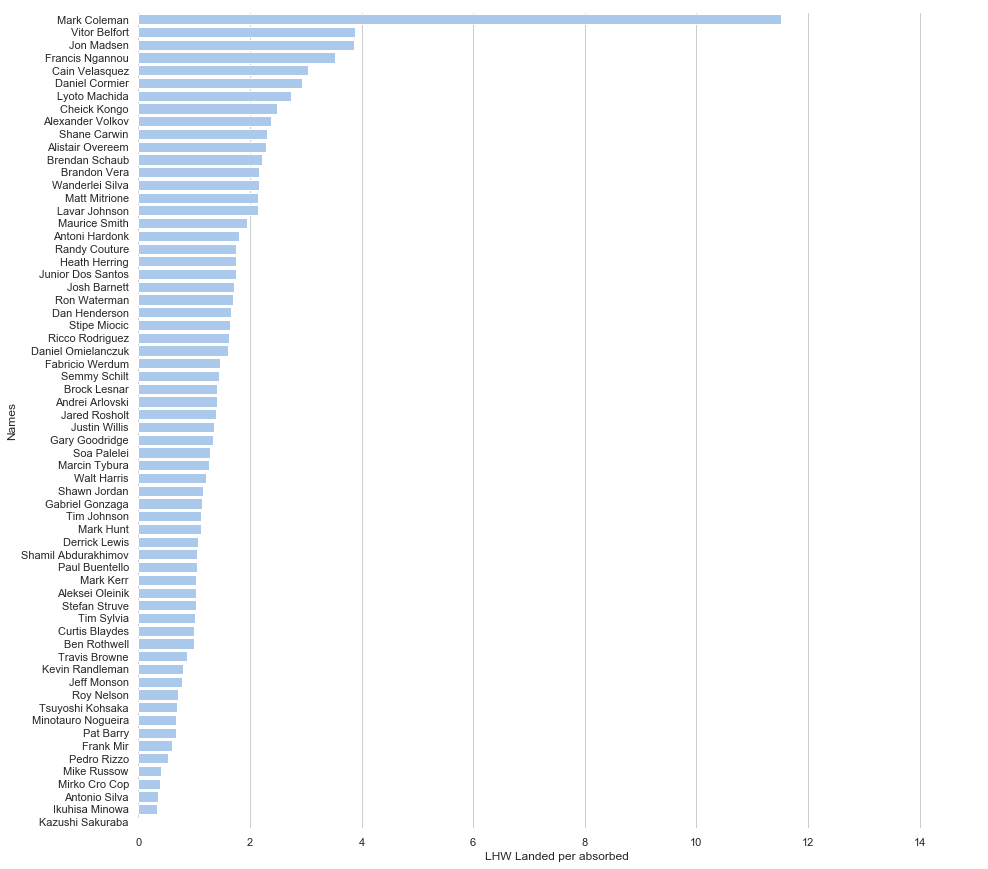

In [43]:
visless = visless[np.invert(visless['strikes_to_get_knocked_out'].isna())]

In [ ]:
distance_visual = table[["Name","UFC","sig f DISTANCE lan","sig o DISTANCE lan","approx_length",'weightclass',"Last Fight","Sig Absorb pm","Sig Land pm","Woman"]].copy()

distance_visual['DISTANCE_lan_pm'] = distance_visual["sig f DISTANCE lan"].values / distance_visual["approx_length"].values
distance_visual['DISTANCE_abs_pm'] = distance_visual["sig o DISTANCE lan"].values / distance_visual["approx_length"].values

distance_visual = distance_visual[distance_visual['Woman'] == 0]

vis = distance_visual[(distance_visual['weightclass'] == 'Lightweight') & (distance_visual['UFC']==1)].groupby('Name').agg({'DISTANCE_abs_pm':'mean','DISTANCE_lan_pm':'mean','UFC':'sum'})

visless =  vis[vis['UFC'] > 4]

visless.columns

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(70,70)
ax.scatter(visless["DISTANCE_abs_pm"],visless["DISTANCE_lan_pm"],marker='x',s=100,c='r')
ax.set_xlabel('Significant strikes from distance absorbed per minute',size=60)
ax.set_ylabel('Significant strikes from distance landed per minute',size=60)

for xx in visless.iterrows():
    ax.annotate(xx[0], (xx[1][0], xx[1][1]),textcoords='offset points',xytext=(-30,3),size=28)
plt.savefig('SigStrieks Lightweight distance.png',dpi=150)

In [55]:
#hits per knocked down

In [56]:
distance_visual = table[["Name","UFC","tot f SIG STR lan","tot o SIG STR lan","approx_length",'weightclass',"tot o KD",
                         "SinceLastFight","Sig Absorb pm","Sig Land pm","UFC win","SinceLastFight_UFC",'SinceThisFight']].copy()

In [57]:
vis = distance_visual[(distance_visual['weightclass'] == 'Heavyweight') & (distance_visual['UFC']==1)].groupby('Name').agg({'tot o SIG STR lan':'sum',
                                                                                                                                  'tot o KD':'sum',
                                                                                                                                  'UFC win':'sum',
                                                                                                                                 "SinceLastFight_UFC":'min'})

vis['strikes_to_get_knocked_out'] = vis['tot o SIG STR lan'] / vis['tot o KD']
visless =  vis[vis['UFC win'] >= 4]

In [ ]:
visless.sort_values(by="absorbedXlandedRel",ascending=False,inplace=True)

In [61]:
visless = visless[np.invert(visless.strikes_to_get_knocked_out.isna())].sort_values(by="strikes_to_get_knocked_out",ascending=True)

In [65]:
visless['strikes_to_get_knocked_out'].replace({np.inf:np.nan},inplace=True)
visless = visless[np.invert(visless['strikes_to_get_knocked_out'].isna())]

In [67]:
visless.reset_index(inplace=True)

In [79]:
visless.describe()

,tot o SIG STR lan,tot o KD,UFC win,SinceLastFight_UFC,strikes_to_get_knocked_out
count,52.000000,52.000000,52.000000,52,52.000000
mean,352.961538,3.865385,9.442308,959 days 10:25:50.712551,132.543687
std,237.914795,3.726055,5.218419,1098 days 04:26:24.173775,109.554475
min,62.000000,1.000000,4.000000,27 days 15:58:09.174090,20.666667
25%,175.750000,1.000000,5.750000,104 days 15:58:09.174090,61.687500
50%,258.500000,3.000000,8.500000,416 days 03:58:09.174090,89.750000
75%,447.750000,4.250000,12.000000,1399 days 15:58:09.174090,170.012500
max,1009.000000,22.000000,24.000000,3835 days 15:58:09.174090,579.000000


In [82]:
visless['strikes_to_get_knocked_out']

0      20.666667
1      32.500000
2      35.727273
3      38.000000
4      39.000000
5      45.000000
6      52.333333
7      54.000000
8      57.333333
9      57.500000
10     58.250000
11     59.000000
12     61.250000
13     61.833333
14     63.000000
15     65.333333
16     65.500000
17     71.666667
18     74.333333
19     77.100000
20     78.416667
21     81.000000
22     81.444444
23     84.000000
24     86.800000
25     89.500000
26     90.000000
27    101.500000
28    110.000000
29    112.000000
30    114.000000
31    119.600000
32    140.000000
33    144.500000
34    149.000000
35    152.000000
36    163.500000
37    164.000000
38    169.600000
39    171.250000
40    172.000000
41    189.000000
42    196.000000
43    201.000000
44    213.500000
45    228.000000
46    246.000000
47    255.000000
48    273.000000
49    336.333333
50    512.000000
51    579.000000
Name: strikes_to_get_knocked_out, dtype: float64

In [99]:
from matplotlib import rcParams

C:\Users\User\Anaconda3\envs\ml\lib\site-packages\matplotlib\artist.py:913: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  return func(v)


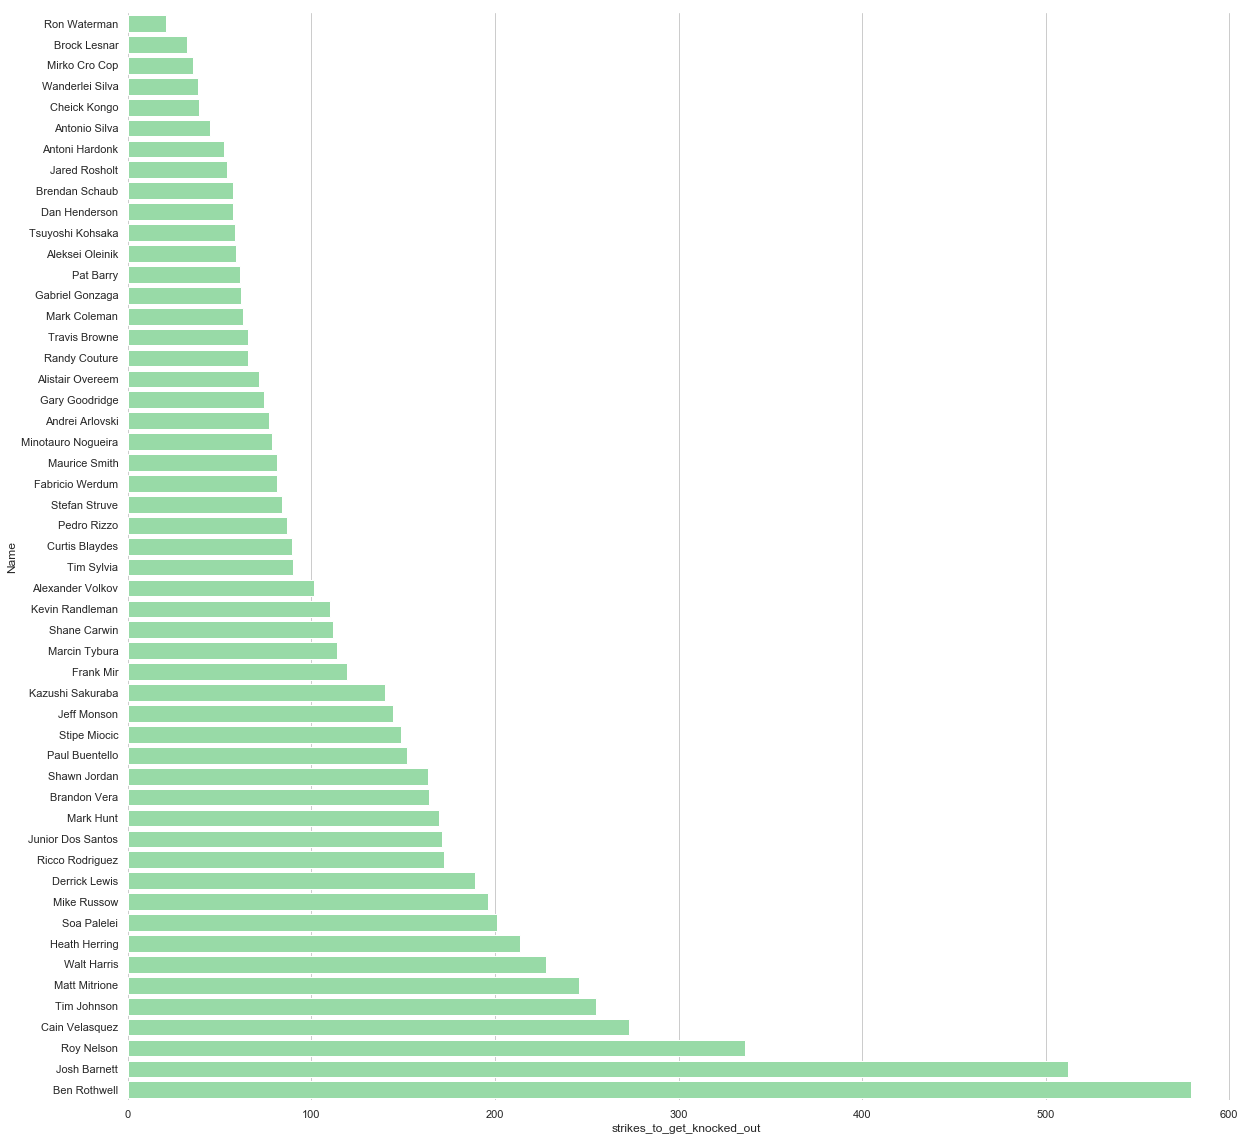

In [101]:
sns.set(style="whitegrid")
#f, ax = plt.subplots(figsize=(20, 10))

# Plot the total crashes
sns.set_color_codes("pastel")

sns.barplot(x="strikes_to_get_knocked_out", y="Name", data=visless,
            label="Punches to get knocked downed", color="g")


rcParams['figure.figsize'] = 24,24
ax.set_xscale("log")
# Plot the crashes where alcohol was involved
sns.set_color_codes("dark")

# Add a legend and informative axis label
ax.set(xlim=(0, 24), ylabel="", xlabel="Automobile collisions per billion miles")

sns.despine(left=True, bottom=True)

In [24]:
table.columns.values

array(['Name', 'Woman', 'Nickname', 'Height in', 'Reach in', 'Stance',
       'Sig Land pm', 'Strik acc', 'Sig Absorb pm', 'Strik def', 'TD Avg',
       'TD acc', 'TD Def', 'Sub Avg', 'DoB', 'Height cm', 'Wins', 'Loses',
       'draws', 'nc', 'Affil', 'National', 'Loc reg', 'Loc city', 'W KO',
       'W sub', 'W dec', 'W oth', 'L KO', 'L sub', 'L dec', 'L oth',
       'Giv name', 'Reach cm', 'Height cm.1', 'Last Fight', 'Born',
       'Fight out of', 'fr wins', 'fr loses', 'fr draws', 'opponent',
       'or wins', 'or loses', 'or draws', 'result', 'round', 'time',
       'method', 'decision', 'injuries', 'weightclass', 'wcls weight',
       'weigh-in', 'fighter title', 'fights title name', 'referee',
       'fight time', 'billing', 'odds', 'event', 'pay', 'date',
       'dc reason', 'UFC', 'fight bonus', 'perf bonus', 'sub bonus',
       'ko bonus', 'off method', 'off round', 'title fight', 'details',
       'off time', 'time format', 'off referee', 'f card1', 'op card1',
       'f car

In [71]:
visual = table[["Name","UFC",'Height cm', 'Reach cm','weightclass',"SinceThisFight"]].copy()
visual = visual[(visual.weightclass == "Middleweight") | (visual.weightclass == "Welterweight")]

In [72]:
mdws = visual[(visual['weightclass'] == 'Middleweight') & (visual['UFC']==1)].groupby('Name').agg({'Height cm':'mean','Reach cm':'mean',"UFC":'sum',"SinceThisFight":'min'})
wws =  visual[(visual['weightclass'] == 'Welterweight') & (visual['UFC']==1)].groupby('Name').agg({'Height cm':'mean','Reach cm':'mean',"UFC":'sum',"SinceThisFight":'min' })

mdws =  mdws[mdws['UFC'] > 4]
wws = wws[wws['UFC'] > 4]

In [73]:
mdws = mdws[mdws.SinceThisFight.dt.days < 500]

In [74]:
wws = wws[wws.index == "Darren Till"]

In [75]:
combined = pd.concat([mdws,wws])

In [86]:
combined['Height cm'] = combined['Height cm'].round()
combined['Reach cm'] = combined['Reach cm'].round()

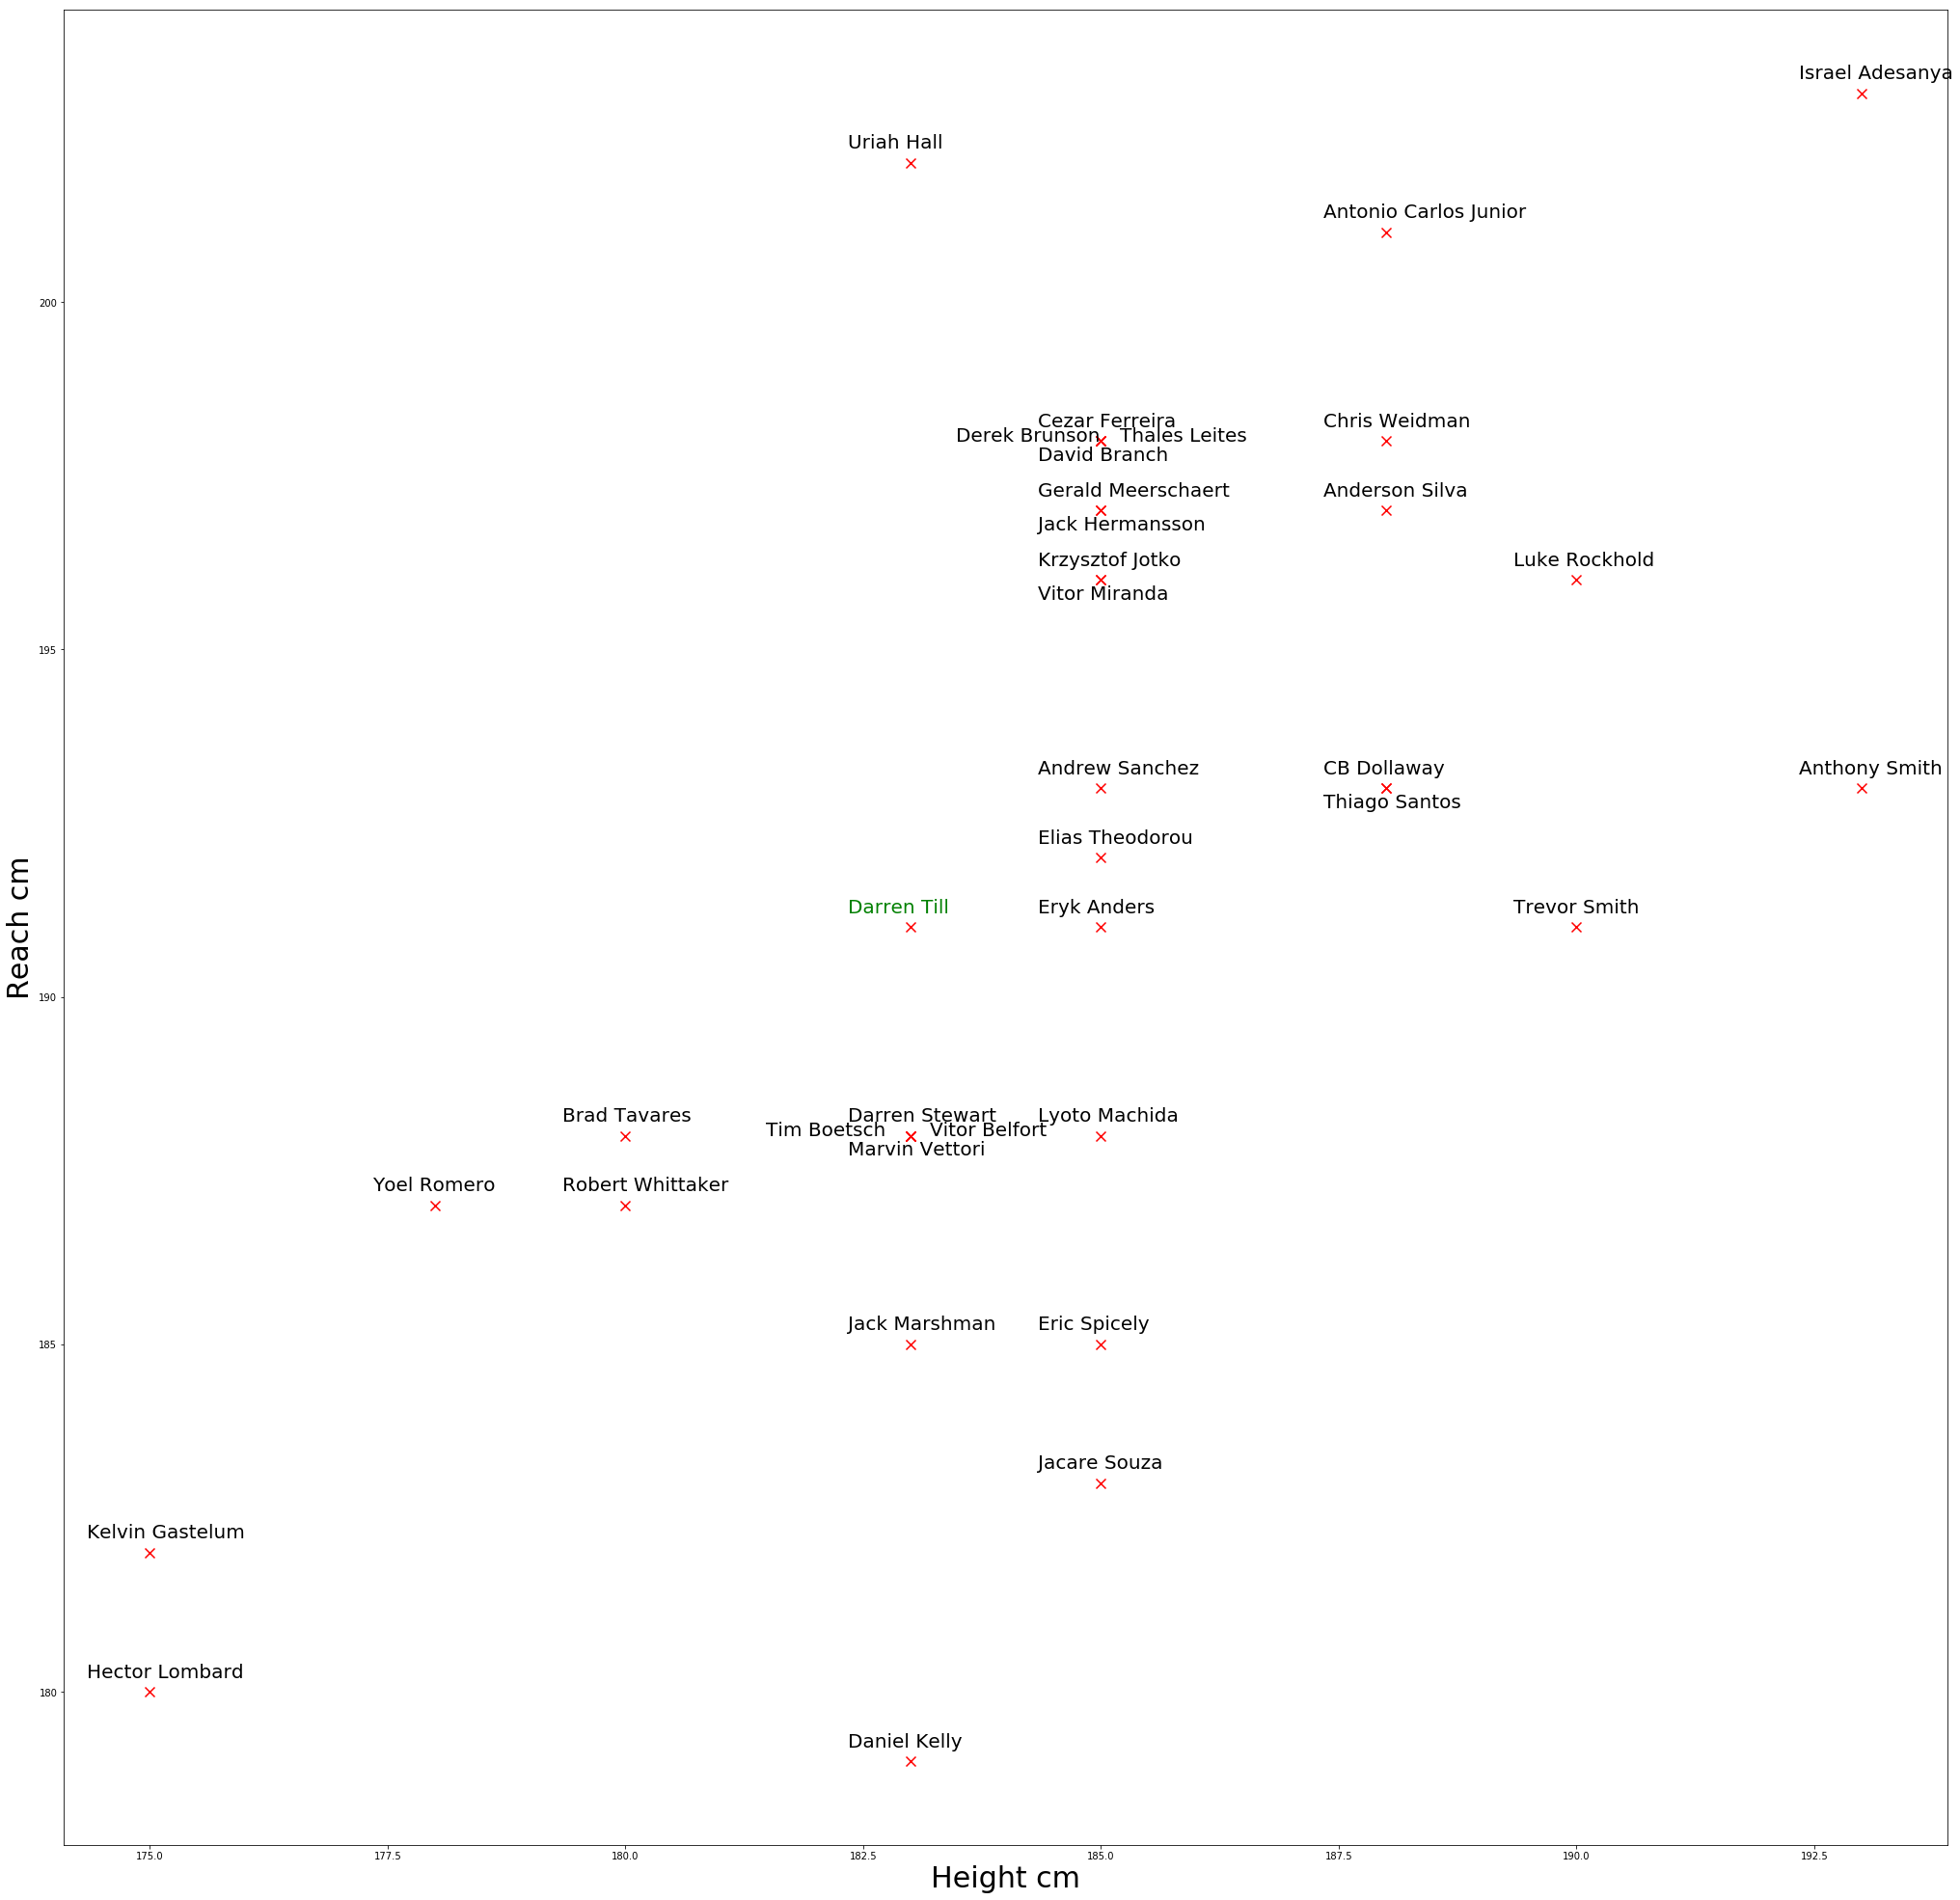

In [120]:
fig, ax = plt.subplots()
fig.set_size_inches(35,35)
ax.scatter(combined["Height cm"],combined["Reach cm"],marker='x',s=100,c='r')

ax.set_xlabel('Height cm',size=30)
ax.set_ylabel('Reach cm',size=30)

number_dict = {}
for xx in combined.iterrows():
    height = xx[1][0]
    reach = xx[1][1]
    
    clr = 'black'
    if xx[0] == 'Darren Till':
        clr = 'green'
    
    if (height,reach) not in number_dict:
        number_dict[(height,reach)] = 1
    else:
        number_dict[(height,reach)] += 1
    
    
    if number_dict[(height,reach)] == 2:
        ax.annotate(xx[0], (height, reach),textcoords='offset points',xytext=(-65,-20),size=20,color=clr)
    elif number_dict[(height,reach)] == 3:
        ax.annotate(xx[0], (height, reach),textcoords='offset points',xytext=(-150,0),size=20,color=clr)
    elif number_dict[(height,reach)] == 4:
        ax.annotate(xx[0], (height, reach),textcoords='offset points',xytext=(+20,0),size=20,color=clr)
    
    else:
        ax.annotate(xx[0], (height, reach),textcoords='offset points',xytext=(-65,15),size=20,color=clr)
plt.savefig('height to reach.png',dpi=150)

In [16]:
#different weight classes height/medium height on  classes height/medium weight

In [7]:
visual = table[["Name","UFC",'Height cm', 'Reach cm','weightclass',"SinceThisFight",'Height cm','Reach cm']].copy()
visual = visual[visual['UFC'] == 1]

In [8]:
visual.weightclass.unique()

array([nan, 'Heavyweight', 'Light Heavyweight', 'Catchweight',
       'Middleweight', 'Lightweight', 'Super Heavyweight', 'Welterweight',
       'Bantamweight', 'Featherweight', 'Flyweight',
       'Women Featherweight', 'Women Bantamweight', 'Women Flyweight',
       'Women Catchweight', 'Women Strawweight', 'Women Welterweight',
       'Women Atomweight'], dtype=object)

In [ ]:
for wcls in ['Heavyweight', 'Light Heavyweight', 'Middleweight', 'Lightweight', 'Welterweight', 'Bantamweight', 'Featherweight', 'Flyweight',
       'Women Featherweight', 'Women Bantamweight', 'Women Flyweight','Women Strawweight', 'Women Welterweight',]:
    

In [9]:
visual[visual.weightclass.isna()]

,Name,UFC,Height cm,Reach cm,weightclass,SinceThisFight,Height cm,Reach cm
0,Royce Gracie,1,182.88,NaN,NaN,9334 days 17:25:59.417077,182.88,NaN
1,Royce Gracie,1,182.88,NaN,NaN,9334 days 17:25:59.417077,182.88,NaN
2,Royce Gracie,1,182.88,NaN,NaN,9334 days 17:25:59.417077,182.88,NaN
3,Royce Gracie,1,182.88,NaN,NaN,9215 days 17:25:59.417077,182.88,NaN
4,Royce Gracie,1,182.88,NaN,NaN,9215 days 17:25:59.417077,182.88,NaN
5,Royce Gracie,1,182.88,NaN,NaN,9215 days 17:25:59.417077,182.88,NaN
6,Royce Gracie,1,182.88,NaN,NaN,9215 days 17:25:59.417077,182.88,NaN
7,Royce Gracie,1,182.88,NaN,NaN,9033 days 17:25:59.417077,182.88,NaN
8,Royce Gracie,1,182.88,NaN,NaN,8935 days 17:25:59.417077,182.88,NaN
9,Royce Gracie,1,182.88,NaN,NaN,8935 days 17:25:59.417077,182.88,NaN
